In [15]:
from docplex.mp.model import Model
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

import helper_functions as hf
import importlib
importlib.reload(hf)

<module 'helper_functions' from '/home/lema/Documents/diplomska/dai/helper_functions.py'>

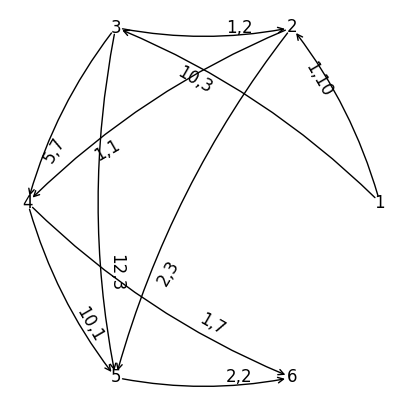

In [58]:
# dolocis podatke: graf, cene, kapacitete, povpraševanja
edges = [(1,2),(1,3),(3,2),(2,4),(2,5),(3,4),(3,5),(4,5),(4,6),(5,6)]
c = [1,10,1,1,2,5,12,10,1,2]
cap = [10,3,2,1,3,7,3,1,7,2]


c_dict = dict(zip(edges, c))
cap_dict = dict(zip(edges, cap))

# konstruiraš graf iz podatkov
graph = nx.DiGraph()
graph.add_edges_from(edges)



nx.set_edge_attributes(graph, c_dict,"c")
nx.set_edge_attributes(graph, cap_dict,"cap")


hf.plot_multigraph(graph,with_labels=True,font_size=12,figure_size=(5,5))


In [59]:
demands = [(0,3,1),(0,4,3),(0,5,2)]

n = len(graph.nodes()) # 6 # |V|
m = len(graph.edges()) # 10 # |E|
t = len(demands) # 3

def demands_to_matrix(demands,n):
    H = np.zeros((n,len(demands)))
    for k,(Ok,Dk,d) in enumerate(demands):
        H[Ok,k] = d
        H[Dk,k] = -d
    return H      

H = demands_to_matrix(demands,n)

In [4]:
H.shape

(6, 3)

In [60]:
c = np.round(np.array([data["c"] for _,_, data in graph.edges(data=True)])) # BŠS
cap = np.floor(np.array([data["cap"] for _,_, data in graph.edges(data=True)])) # caps floor to int
B = -1 * np.array(nx.incidence_matrix(graph,oriented=True).todense())

In [102]:
from docplex.mp.progress import *
import os
def cplex_solver(c, cap, B, H, time_limit = 20):
    n,m = B.shape
    _,t = H.shape

    milp_model = Model(name = "myMILP")
    # milp_model.set_time_limit(time_limit) #The same
    # milp_model.parameters.timelimit=1

    commodities = np.arange(t)

    edges = np.arange(m)#list(graph.edges())
    nodes = np.arange(n)#list(graph.nodes())

    X = milp_model.integer_var_matrix(edges, commodities, lb = 0, name="X")

    # cost = c.T @ np.sum(X,axis=1)
    cost_expr = milp_model.sum(X[edge, com] * c[edge] for edge in edges for com in commodities)

    # vp["B"] @ vp["X"] == vp["H"]
    for node in nodes:
        for com in commodities:
            milp_model.add_constraint(milp_model.sum(X[edge, com] * B[node, edge] for edge in edges)  == H[node, com])

    # (cp.sum(vp["X"],axis=1) <= vp["cap"])
    for edge in edges:
        milp_model.add_constraint(milp_model.sum(X[edge, com] for com in commodities)  <=  cap[edge])


    milp_model.set_objective("min", cost_expr)
    # milp_model.context.solver.time_limit = 1
    # milp_model.parameters.dettimelimit = 1
    # milp_model.set_time_limit(1) #The same
    # milp_model.parameters.mip.limits.nodes = 1

    milp_model.print_information()
    
    

    # connect a listener to the model
    milp_model.add_progress_listener(TextProgressListener())


    
    
    
    # sol = milp_model.solve(TimeLimit=1)
    sol = milp_model.solve(clean_before_solve=True)
    
    print(sol.solve_details)
    # milp_model.print_solution()
    # milp_model.export_as_lp_string()
    # sol = milp_model.get_solve_details()
    X_dict_sol = {}
    for com in commodities:
        for edge in edges:
            if sol[X[edge,com]] != 0:
                X_dict_sol[(edge,com)] = sol[X[edge,com]]
    print(X_dict_sol)
    return (X_dict_sol, sol.objective_value)



In [103]:
X_dict, opt_val = cplex_solver(c, cap, B, H)

Model: myMILP
 - number of variables: 741
   - binary=0, integer=741, continuous=0
 - number of constraints: 616
   - linear=616
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
status  = integer optimal solution
time    = 0.0242 s.
problem = MILP
gap     = 0%

{(12, 0): 1.0, (12, 1): 1.0, (13, 1): 2.0, (43, 1): 1.0, (159, 1): 2.0, (177, 1): 2.0, (180, 1): 2.0, (203, 1): 1.0, (215, 1): 1.0, (225, 1): 2.0, (12, 2): 2.0, (41, 2): 2.0, (220, 2): 2.0}


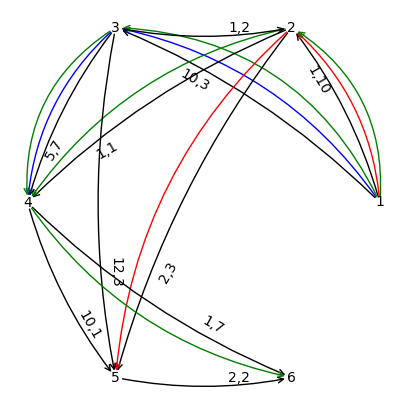

In [29]:
hf.plot_solution_graph_from_dict(graph,X_dict,with_labels=True,font_size=10,figure_size=(5,5))

In [99]:
import pickle
file = open('/home/lema/Documents/diplomska/dai/helsinki_nx.pkl', 'rb')
graph = pickle.load(file)
file.close()

In [100]:
c = np.round(np.array([data["c"] for _,_, data in graph.edges(data=True)])) # BŠS
cap = np.floor(np.array([data["cap"] for _,_, data in graph.edges(data=True)])) # caps floor to int

B = -1 * np.array(nx.incidence_matrix(graph,oriented=True))

n,m = B.shape

demands = [(15,91,5)]
demands = [(6,20,1),(6,100,3),(6,105,2)]
H = demands_to_matrix(demands,n)


In [101]:
X_dict, opt_val = cplex_solver(c, cap, B, H)

Model: myMILP
 - number of variables: 741
   - binary=0, integer=741, continuous=0
 - number of constraints: 616
   - linear=616
 - parameters:
     parameters.mip.limits.nodes = 1
 - objective: minimize
 - problem type is: MILP
status  = integer optimal solution
time    = 0.0263619 s.
problem = MILP
gap     = 0%

{(12, 0): 1.0, (12, 1): 1.0, (13, 1): 2.0, (43, 1): 1.0, (159, 1): 2.0, (177, 1): 2.0, (180, 1): 2.0, (203, 1): 1.0, (215, 1): 1.0, (225, 1): 2.0, (12, 2): 2.0, (41, 2): 2.0, (220, 2): 2.0}


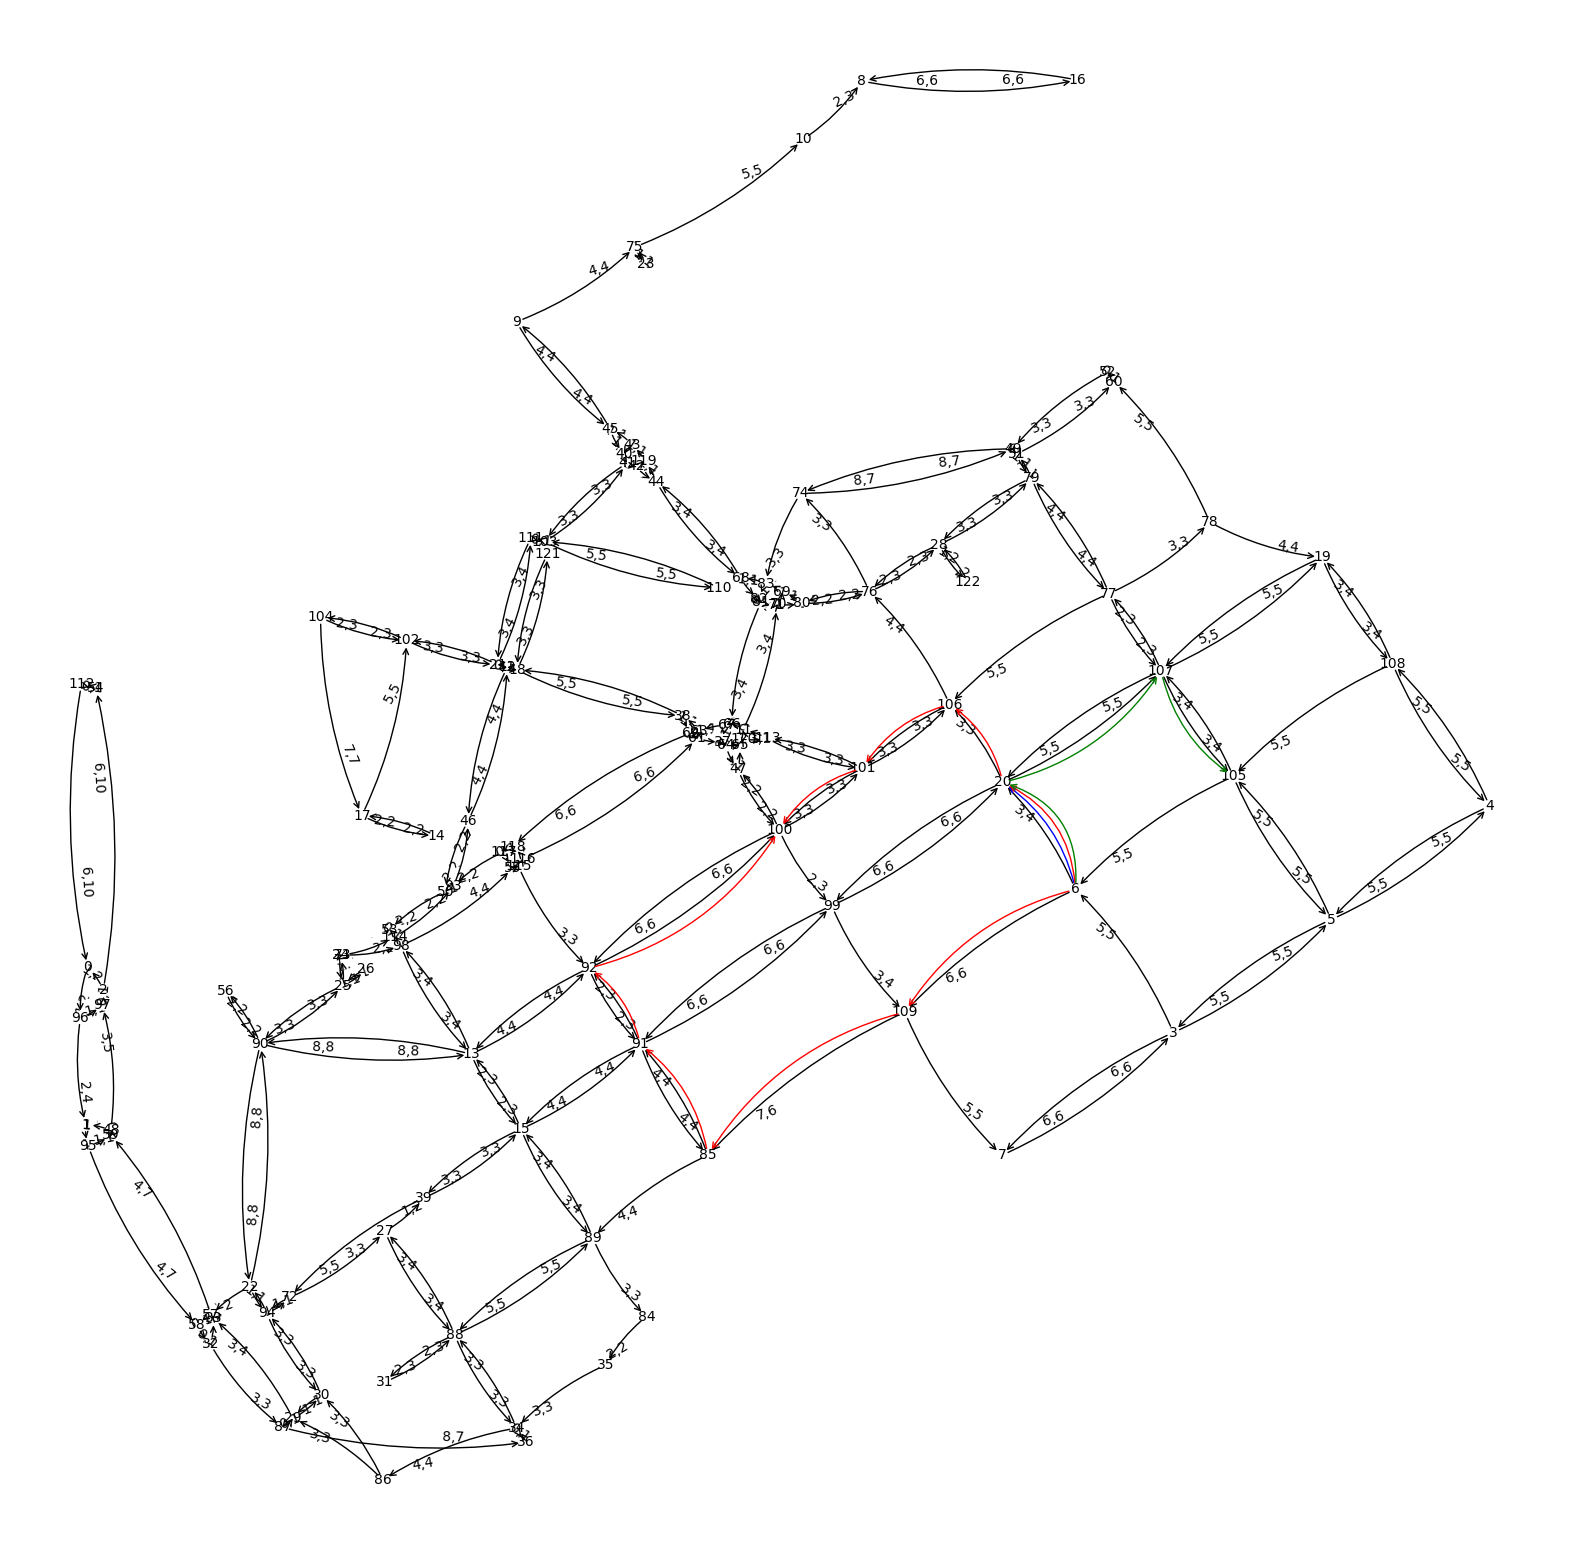

In [42]:
hf.plot_solution_graph_from_dict(graph,X_dict,with_labels=True,font_size=10,figure_size=(20,20))

In [91]:
import pickle
file = open('/home/lema/Documents/diplomska/dai/lj_nx.pkl', 'rb')
graph = pickle.load(file)
file.close()

In [92]:
c = np.round(np.array([data["c"] for _,_, data in graph.edges(data=True)])) # BŠS
cap = np.floor(np.array([data["cap"] for _,_, data in graph.edges(data=True)])) # caps floor to int

B = -1 * np.array(nx.incidence_matrix(graph,oriented=True))

n,m = B.shape

demands = [(15,91,5)]
demands = [(6,20,1),(6,100,3),(6,105,2)]
H = demands_to_matrix(demands,n)

In [93]:
X_dict, opt_val = cplex_solver(c, cap, B, H, time_limit=1)

KeyboardInterrupt: 